In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Assignment 2

### Task 2.1 - 2.2

In [183]:
def arbitrary_poly(params):
    return np.poly1d(params[::-1])

# params: [theta_0, theta_1, ... , theta_n], where n = model order and theta_0 is bias 
true_params = [1,-2,5]
y_model = arbitrary_poly(true_params)
u = np.linspace(start=-3, stop=3, num=201)

# Hyperparameters for the type of noise-generating distribution.
alpha = 0         # probability in mixture model
mean = 0          # mean parameter 
sigma = 1         # std dev parameter Gaussian
beta = 1          # scaling parameter Laplacian
N = 201           # number of samples
gamma = 0.3       # probability of faulty measure

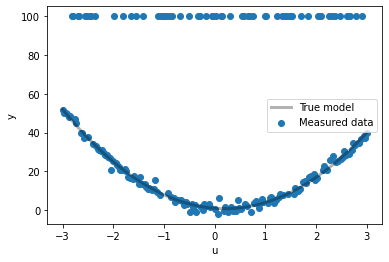

In [184]:
# The Laplace probability density function:
# Also available in library "scipy.stats.laplace"
def laplace_pdf(x, loc, scale):
    return (1.0/(2.0 * scale)) * np.exp( -np.abs(x-loc) / scale)

# Generate data points
def generate_data(model=y_model, inputs=u, alpha=alpha, mean=mean, sigma=sigma, beta=beta, N=N, gamma=gamma):
    y_true = y_model(u)

    # Generate noise
    noise = np.zeros(N)
    for i in range(N):
        if np.random.uniform(0, 1) <= alpha:
            # Gaussian when event with probability alpha
            noise[i] = np.random.normal(mean, sigma)
        else:
            # Laplacian when event with probability alpha - 1
            noise[i] = np.random.laplace(mean, beta)

    # Add noise to the generated data points - thus simulating measurement
    y = y_true + noise

    # Add possibility of faulty measurements
    for i in range(N):
        if np.random.uniform(0, 1) <= gamma:
            y[i] = 100
    return y

y = generate_data()
        
# Plot measured data
plt.scatter(u, y, label=r"Measured data")
plt.plot(u, y_model(u), "k", alpha=0.3, lw=3, label="True model")
plt.legend()
plt.xlabel("u")
plt.ylabel("y");

### Task 2.3

In [156]:
def LS_estimate(measured_data, input_data, model_order, num_samples):
    # Step 1
    # Matrix form
    u_tensor_0 = np.reshape(input_data,(num_samples,1))
    ones_vec = np.ones((num_samples,1))
    u_tensor = np.append(ones_vec, u_tensor_0, axis=1)

    for i in range(2,model_order):
        u_tensor = np.append(u_tensor, np.power(u_tensor_0, i) ,axis=1)
    
    # Step 2
    u_transpose_dot_u = np.dot(u_tensor.T,u_tensor)  # calculating dot product
    u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u) #calculating inverse
    
    # Step 3
    u_transpose_dot_y = np.dot(u_tensor.T, measured_data)  # calculating dot product
    
    # Step 4
    LS_params = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)

    # Recreate model based on LS estimate:
    LS_params = LS_params.tolist()
    
    return LS_params

In [157]:
def log_lik(par_vec, y, x):
    # If the standard deviation parameter is negative, return a large value:
    if par_vec[-1] < 0:
        return(1e8)
    # The likelihood function values:
    lik = laplace_pdf(y,
              loc = sum([p*(x**i) for i, p in enumerate(par_vec[:-1])]),
              scale = par_vec[-1])
    
    #This is similar to calculating the likelihood for Y - XB
    # res = y - par_vec[0] - par_vec[1] * x
    # lik = norm.pdf(res, loc = 0, sd = par_vec[2])
    
    # If all logarithms are zero, return a large value
    if all(v == 0 for v in lik):
        return(1e8)
    # Logarithm of zero = -Inf
    return(-sum(np.log(lik[np.nonzero(lik)])))

In [158]:
import scipy.optimize as optimize

def MLE_estimate(lik_func, measured_data, input_data, model_order, num_samples):
    # The likelihood function includes the scale (std dev) parameter which is also estimated by the optimized
    # therefore the initial guess verctor has length n+2 [theta_0_hat, theta_1_hat, ... , theta_n_hat, sigma_hat]
    init_guess = np.zeros(model_order+1)
    init_guess[-1] = num_samples

    # Do Maximum Likelihood Estimation:
    opt_res = optimize.minimize(fun = lik_func,
                                x0 = init_guess,
                                #options={'disp': True},
                                args = (measured_data, input_data))

    MLE_params = opt_res.x[:-1]
    
    return MLE_params

### Task 2.4

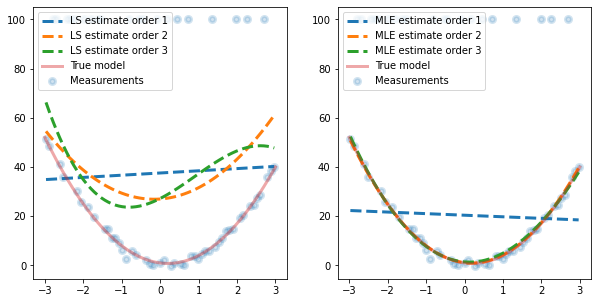

In [181]:
# Guess what order the model is:
order_guesses = np.arange(2,5, dtype="int") # number coincides with # of parameters, i.e. (order+1)

LS_params = []
MLE_params = []

def split_datasets(u, y):
    # Split the dataset into train, test and validation sets
    X_train, X_test, X_val = np.array([]), np.array([]), np.array([])
    y_train, y_test, y_val = np.array([]), np.array([]), np.array([])

    for i in range(len(u)):
        if i%3 == 0:
            X_train = np.append(X_train, u[i])
            y_train = np.append(y_train, y[i])
        elif i%3 == 1:
            X_test = np.append(X_test, u[i])
            y_test = np.append(y_test, y[i])
        else:
            X_val = np.append(X_val, u[i])
            y_val = np.append(y_val, y[i])
    return X_train, X_test, X_val, y_train, y_test, y_val

X_train, X_test, X_val, y_train, y_test, y_val = split_datasets(u, y)

for o in order_guesses:
    LS_params.append(LS_estimate(y_train, X_train, o, X_train.size))
    MLE_params.append(MLE_estimate(log_lik, y_train, X_train, o, X_train.size))
    
y_predict_LS = []
y_predict_MLE = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
for i, params in enumerate(LS_params):
    model = arbitrary_poly(params)
    y_predict_LS.append(model)
    ax1.plot(X_test, model(X_test), "--", alpha = 1, lw=3, label="LS estimate order {}".format(i+1))
for i, params in enumerate(MLE_params):
    model = arbitrary_poly(params)
    ax2.plot(X_test, model(X_test), "--", alpha = 1, lw=3, label="MLE estimate order {}".format(i+1))
    y_predict_MLE.append(model)
    
ax1.scatter(X_test, y_test, alpha = 0.2 ,lw=3, label="Measurements")
ax1.plot(u0, y_true, alpha = 0.4 ,lw=3, label="True model")
ax1.legend(loc='upper left')
ax2.scatter(X_test, y_test, alpha = 0.2 ,lw=3, label="Measurements")
ax2.plot(u0, y_true, alpha = 0.4 ,lw=3, label="True model")
ax2.legend(loc='upper left')
plt.savefig("Estimates_gamma=0.3.png")

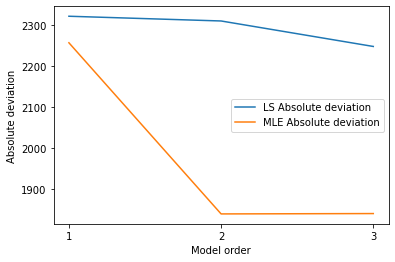

In [182]:
def abs_deviation(y_hat,y):
    return np.sum(np.abs(y_hat - y))

deviation_LS = []
deviation_MLE = []

# Calculate deviation for all of the fitted models:
for i, (_mle, _ls) in enumerate(zip(y_predict_MLE, y_predict_LS)):
    deviation_MLE.append(abs_deviation(_mle(X_val),y_val))
    deviation_LS.append(abs_deviation(_ls(X_val),y_val))

plt.figure()
plt.plot(order_guesses-1, deviation_LS, label="LS Absolute deviation")
plt.plot(order_guesses-1, deviation_MLE, label="MLE Absolute deviation")
plt.legend()
plt.xlabel("Model order")
plt.xticks(order_guesses-1)
plt.ylabel("Absolute deviation")
plt.savefig("Performance_gamma=0.3.png")
plt.show()

### Task 2.5

Absolute deviation of MLE and LS estimates with $\gamma = 0.03$:

![Performance0.03](Performance_gamma=0.03.png)

Estimates using LS and MLE with $\gamma = 0.03$:

![Estimation0.03](Estimates_gamma=0.03.png)

From the plot we can see that model order 2 is needed to get a low absolute deviation, and increasing the model order further gives barely any increase in performance. This tells me I should choose a model order of 2, as I want the simplest model which can sufficiently estimate the true model. We also see that LS has a higher absolute deviation than MLE. In addition we can see that MLE results in a much better estimate of the measurements and the true model. MLE includes a sort of outlier handling which LS is not as robust towards. Therefore I would choose second order MLE as my estimator. 

When increasing gamma the difference between LS and MLE become more and more clear. The following plot shows the estimates with $\gamma = 0.1$.

![Estimation0.1](Estimates_gamma=0.1.png)

And absolute deviation with $\gamma = 0.1$:

![Performance0.1](Performance_gamma=0.1.png)

We can see that the MLE estimates are still very close to the true model, while the LS estimates diverge more. The absolute deviation also increased a lot more for LS than for MLE. Increasing $\gamma$ further makes these differences even larger as seen when $\gamma = 0.3$.

![Performance0.3](Performance_gamma=0.3.png)

![Estimation0.3](Estimates_gamma=0.3.png)

Here we see MLE starts suffering a tiny bit from too many faulty measurements, while the LS estimators completely break down. For me the choice of estimator is easier for high gamma values, where the differences become increasingly clear.

### 2.6

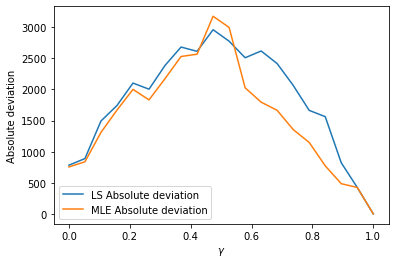

In [194]:
deviation_LS = []
deviation_MLE = []
g = np.linspace(start=0, stop=1, num=20)
for gamma in g:
    y = generate_data(gamma = gamma)
    X_train, X_test, X_val, y_train, y_test, y_val = split_datasets(u, y)
    LS_params = (LS_estimate(y_train, X_train, 2, X_train.size))
    MLE_params = (MLE_estimate(log_lik, y_train, X_train, 2, X_train.size))
    LS_model = arbitrary_poly(LS_params)
    MLE_model = arbitrary_poly(MLE_params)
    deviation_LS.append(abs_deviation(LS_model(X_val),y_val))
    deviation_MLE.append(abs_deviation(MLE_model(X_val),y_val))

plt.figure()
plt.plot(g, deviation_LS, label="LS Absolute deviation")
plt.plot(g, deviation_MLE, label="MLE Absolute deviation")
plt.legend()
plt.xlabel("$\gamma$")
plt.ylabel("Absolute deviation")
plt.savefig("Performance_varied_gamma.png")
plt.show()

![Performance](Performance_varied_gamma.png)

a) MLE seems a lot more robust on average.

b) LS performs worse on all values for $\gamma$ except when it is close to 50% where we basically can't say there is a model because half the measurements follow the model $y=100$. For $\gamma > 50%$ the model basically becomes $y=100$ and we again see that MLE performs better than LS. For these reasons I conclude that the performance of LS is the least graceful with increasing $\gamma$.